## Question 1: Undirect Graphical Model (UGM)

![UGM.png](attachment:UGM.png)


Consider a graph with 10 nodes of real random variables (i.e., $x_1, x_2,...,x_{10}$), where the maximal cliques are given as: $C_1=\{x_1, x_2, x_3, x_4, x_5, x_6\}$, $C_2: =\{x_7,x_8,x_9,x_{10}\}$, $C_3={x_5, x_7}$, $C_4 = \{x_6, x_8\}$ (See figure above).

That is, $(x_1, x_2,...,x_6)$ are fully-connected and the potential functions are given as follows:
$$\phi_{C_1}(x_1, x_2,...,x_6) = \exp(-[x_1, x_2,...,x_6] \Sigma^{-1}[x_1, x_2,...,x_6]^T)$$
where
$$\Sigma =
\begin{bmatrix} 
2 & 0.5 & 0.2 & 0.5 & 0.5 & 0.2\\
0.5 & 2 & 0.8 & 0.8 & 0.5 & 0.5\\
0.2 & 0.8 & 1 & 0.2 & 0.1 & 0.1\\
0.5 & 0.8 & 0.2 & 1 & 0.5 & 0.5\\
0.5 & 0.5 & 0.1 & 0.5 & 2 & 0.8\\
0.2 & 0.5 & 0.1 & 0.5 & 0.8 & 2
\end{bmatrix}
$$
Similarly, $(x_7, x_8, x_9, x_{10})$ are fully-connected and the potential functions are given as follows:
$$\phi_{C_2}(x_7, x_8, x_9, x_{10}) = \exp(\Sigma_{i=7}^{10} x_i^4 - \Sigma_{7 \leq i<j \leq 10} x_i^2 x_j^2)$$

Additionally, node 5 and 7 are connected and $\phi_{C_3}(x_5,x_7) = \exp(-x_5^4 x_7^6)$.
And node 6 and node 8 are connected and $\phi_{C_4}(x_6,x_8) = \exp(-x_6^2 x_8^8)$.

(i) Sample 100,000 data points from the pdf of the graphical model $p(x) \propto \prod \phi(x_i)$, where $x$ is real.

(ii) Assume only the samples are given and the potential functions are not known, train neural networks using the above generated data and estimate the energy and the potential function for each maximal clique.


Sampling from the graphical model...


100%|██████████| 1010000/1010000 [00:09<00:00, 107737.77it/s]


Acceptance rate: 0.6920
Final shape of samples: (100000, 10)
Sampling completed and saved to ugm_samples.npy


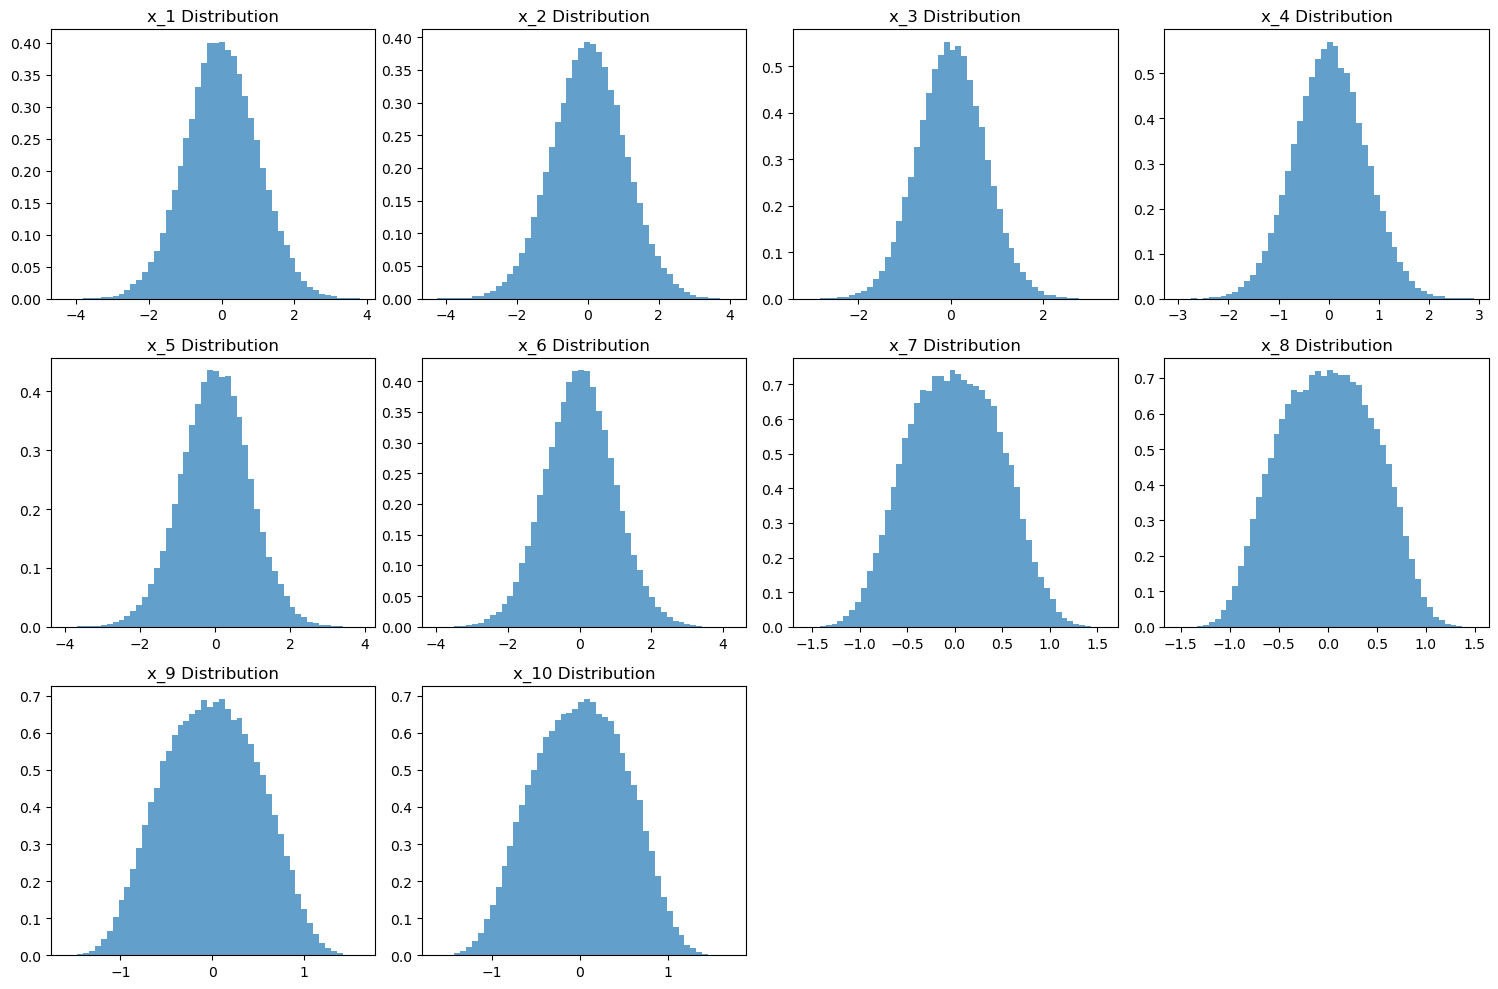

In [1]:
"""Training"""


import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.linalg import inv
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

"""
NOTE [TA's Comment on φ_C2]:
Originally, φ_C2(x) = exp(sum(x^4) - sum(x_i^2 * x_j^2)) led to a divergent 
distribution for large ||x||. I fixed it to be decaying:
    φ_C2(x) = exp( - ( sum(x^4) + sum_{i<j} x_i^2 x_j^2 ) ).
"""



# Define the covariance matrix for clique C1
sigma = np.array([
    [2,   0.5, 0.2, 0.5, 0.5, 0.2],
    [0.5, 2,   0.8, 0.8, 0.5, 0.5],
    [0.2, 0.8, 1,   0.2, 0.1, 0.1],
    [0.5, 0.8, 0.2, 1,   0.5, 0.5],
    [0.5, 0.5, 0.1, 0.5, 2,   0.8],
    [0.2, 0.5, 0.1, 0.5, 0.8, 2  ]
])
precision = inv(sigma)  # Inverse (precision matrix)

def phi_C1(x):
    """Potential for C1 = {x1..x6}"""
    energy = x @ precision @ x.T
    return np.exp(-energy)

def phi_C2(x):
    term1 = np.sum(x**4)
    term2 = 0
    for i in range(4):
        for j in range(i + 1, 4):
            term2 += (x[i]**2) * (x[j]**2)
    return np.exp(- (term1 + term2))

def phi_C3(x5, x7):
    """Potential for C3 = {x5, x7}"""
    return np.exp(-x5**4 * x7**6)

def phi_C4(x6, x8):
    """Potential for C4 = {x6, x8}"""
    return np.exp(-x6**2 * x8**8)

def log_joint_pdf(x):
    log_phi1 = -x[:6] @ precision @ x[:6].T

    # C2 term (decaying form)
    term1 = np.sum(x[6:10]**4)
    term2 = 0
    for i in range(4):
        for j in range(i + 1, 4):
            term2 += (x[6 + i]**2) * (x[6 + j]**2)
    log_phi2 = -(term1 + term2)

    # C3 term
    log_phi3 = - (x[4]**4) * (x[6]**6)

    # C4 term
    log_phi4 = - (x[5]**2) * (x[7]**8)
    return log_phi1 + log_phi2 + log_phi3 + log_phi4

def metropolis_hastings(n_samples, burn_in=10000, thin=10, initial_state=None, step_size=0.15):
    total_iterations = n_samples * thin + burn_in
    if initial_state is None:
        current_state = np.zeros(10)
    else:
        current_state = initial_state
    
    samples = []
    current_log_pdf = log_joint_pdf(current_state)
    accept_count = 0

    for i in tqdm(range(total_iterations)):
        proposal = current_state + step_size * np.random.randn(10)
        proposal_log_pdf = log_joint_pdf(proposal)
        
        alpha = np.exp(proposal_log_pdf - current_log_pdf)
        if np.random.rand() < alpha:
            current_state = proposal
            current_log_pdf = proposal_log_pdf
            accept_count += 1
        
        # Collect samples after burn-in, respecting thinning
        if i >= burn_in and ((i - burn_in) % thin == 0):
            samples.append(current_state.copy())

    acceptance_rate = accept_count / total_iterations
    print(f"Acceptance rate: {acceptance_rate:.4f}")
    return np.array(samples)

print("Sampling from the graphical model...")
# We want 100k final samples, with 10k burn-in, and keep every 10th sample
n_samples = 100000
burn_in = 10000
thin = 10
step_size = 0.15

all_samples = metropolis_hastings(n_samples, burn_in=burn_in, thin=thin, step_size=step_size)
print("Final shape of samples:", all_samples.shape)

np.save('ugm_samples.npy', all_samples)
print("Sampling completed and saved to ugm_samples.npy")

plt.figure(figsize=(15, 10))
for i in range(10):
    plt.subplot(3, 4, i+1)
    plt.hist(all_samples[:, i], bins=50, alpha=0.7, density=True)
    plt.title(f'x_{i+1} Distribution')
plt.tight_layout()
plt.savefig('marginal_distributions.png')
plt.show()

tensor_samples = torch.tensor(all_samples, dtype=torch.float32)

# Split into clique-specific data
C1_data = tensor_samples[:, :6]   # x1..x6
C2_data = tensor_samples[:, 6:10] # x7..x10
C3_data = torch.stack([tensor_samples[:, 4], tensor_samples[:, 6]], dim=1)  # x5, x7
C4_data = torch.stack([tensor_samples[:, 5], tensor_samples[:, 7]], dim=1)  # x6, x8




Training energy model for Clique 1 (x1..x6)
[Epoch 10/100] Train Loss: 0.481223, Val Loss: 0.484279
[Epoch 20/100] Train Loss: 0.484004, Val Loss: 0.481654
[Epoch 30/100] Train Loss: 0.483091, Val Loss: 0.480310
[Epoch 40/100] Train Loss: 0.482421, Val Loss: 0.483988
[Epoch 50/100] Train Loss: 0.480901, Val Loss: 0.482340
[Epoch 60/100] Train Loss: 0.480295, Val Loss: 0.481133
[Epoch 70/100] Train Loss: 0.479505, Val Loss: 0.482074
[Epoch 80/100] Train Loss: 0.480764, Val Loss: 0.482378
[Epoch 90/100] Train Loss: 0.477431, Val Loss: 0.484757
[Epoch 100/100] Train Loss: 0.476101, Val Loss: 0.485322

Training energy model for Clique 2 (x7..x10)
[Epoch 10/100] Train Loss: 0.340412, Val Loss: 0.340654
[Epoch 20/100] Train Loss: 0.341360, Val Loss: 0.342400
[Epoch 30/100] Train Loss: 0.339992, Val Loss: 0.336467
[Epoch 40/100] Train Loss: 0.339466, Val Loss: 0.343587
[Epoch 50/100] Train Loss: 0.338410, Val Loss: 0.338701
[Epoch 60/100] Train Loss: 0.341426, Val Loss: 0.340679
[Epoch 70/10

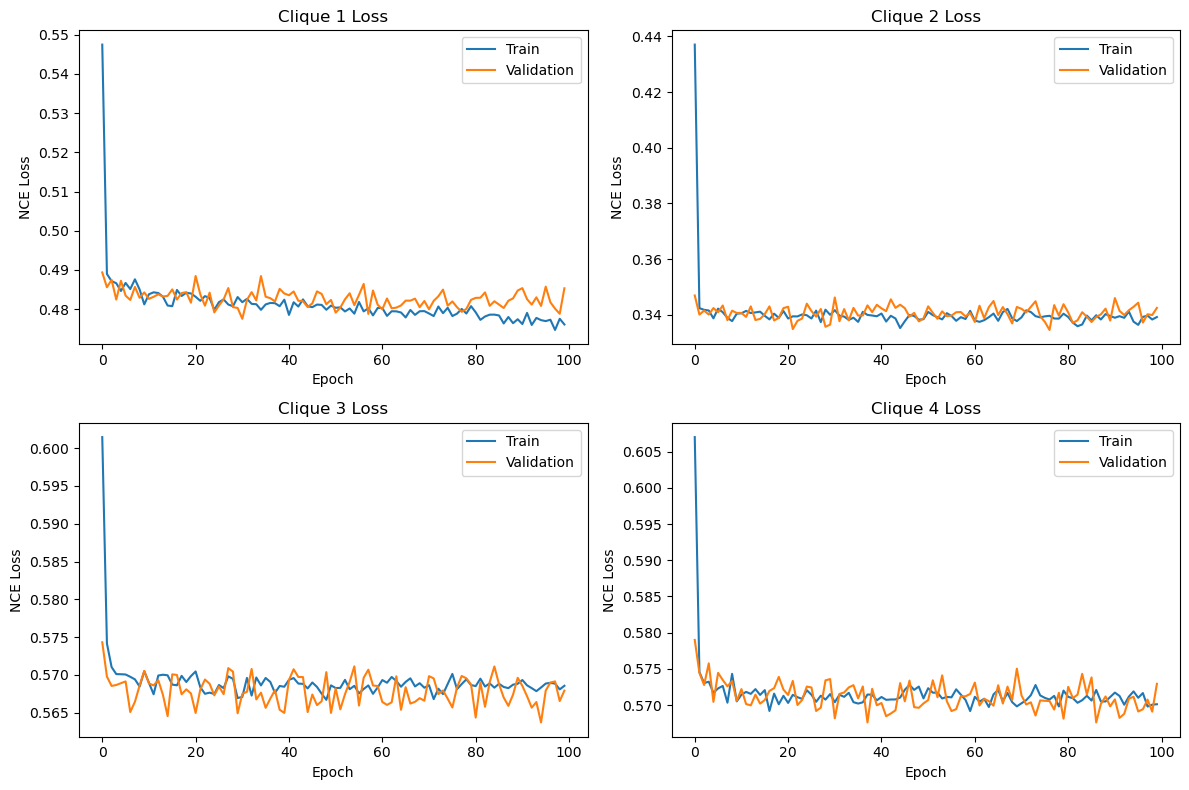

In [2]:
# Basic energy network
class EnergyNet(nn.Module):
    def __init__(self, input_size, hidden_sizes=[256, 256, 128]):
        super().__init__()
        layers = []
        prev_size = input_size
        for h in hidden_sizes:
            layers.append(nn.Linear(prev_size, h))
            layers.append(nn.ReLU())
            prev_size = h
        layers.append(nn.Linear(prev_size, 1))  # outputs scalar energy
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        # x shape: [batch_size, input_size]
        return self.model(x).squeeze(-1)  # shape [batch_size]

# Corrected NCE: sample noise from a known distribution, do logistic classification
class NCELoss(nn.Module):
    def __init__(self, energy_net):
        super().__init__()
        self.energy_net = energy_net
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, real_data):
        batch_size = real_data.size(0)
        noise_data = torch.randn_like(real_data)
        real_energy = self.energy_net(real_data)
        noise_energy = self.energy_net(noise_data)
        real_logits = -real_energy
        noise_logits = -noise_energy
        real_labels = torch.ones_like(real_logits)
        noise_labels = torch.zeros_like(noise_logits)
        loss_real = self.bce(real_logits, real_labels)
        loss_noise = self.bce(noise_logits, noise_labels)
        return 0.5 * (loss_real + loss_noise)

def train_val_split(dataset, val_fraction=0.2):
    n_total = len(dataset)
    n_val = int(val_fraction * n_total)
    n_train = n_total - n_val
    return random_split(dataset, [n_train, n_val])

def train_energy_model(
    data, input_size, hidden_sizes=[256, 256, 128], 
    epochs=100, batch_size=256, lr=1e-4
):
    full_dataset = TensorDataset(data)
    train_dataset, val_dataset = train_val_split(full_dataset, val_fraction=0.2)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
    
    model = EnergyNet(input_size, hidden_sizes)
    criterion = NCELoss(model)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0
        for (batch_data,) in train_loader:
            optimizer.zero_grad()
            loss = criterion(batch_data)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        epoch_train_loss /= len(train_loader)
        
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for (batch_data,) in val_loader:
                val_loss = criterion(batch_data)
                epoch_val_loss += val_loss.item()
        epoch_val_loss /= len(val_loader)
        
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"[Epoch {epoch+1}/{epochs}] "
                  f"Train Loss: {epoch_train_loss:.6f}, Val Loss: {epoch_val_loss:.6f}")
    
    return model, train_losses, val_losses

print("\nTraining energy model for Clique 1 (x1..x6)")
C1_model, C1_train_losses, C1_val_losses = train_energy_model(C1_data, input_size=6)

print("\nTraining energy model for Clique 2 (x7..x10)")
C2_model, C2_train_losses, C2_val_losses = train_energy_model(C2_data, input_size=4)

print("\nTraining energy model for Clique 3 (x5, x7)")
C3_model, C3_train_losses, C3_val_losses = train_energy_model(C3_data, input_size=2)

print("\nTraining energy model for Clique 4 (x6, x8)")
C4_model, C4_train_losses, C4_val_losses = train_energy_model(C4_data, input_size=2)

torch.save(C1_model.state_dict(), 'C1_energy_model.pth')
torch.save(C2_model.state_dict(), 'C2_energy_model.pth')
torch.save(C3_model.state_dict(), 'C3_energy_model.pth')
torch.save(C4_model.state_dict(), 'C4_energy_model.pth')


def plot_train_val_losses(train_losses, val_losses, title):
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('NCE Loss')
    plt.legend()

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plot_train_val_losses(C1_train_losses, C1_val_losses, 'Clique 1 Loss')

plt.subplot(2, 2, 2)
plot_train_val_losses(C2_train_losses, C2_val_losses, 'Clique 2 Loss')

plt.subplot(2, 2, 3)
plot_train_val_losses(C3_train_losses, C3_val_losses, 'Clique 3 Loss')

plt.subplot(2, 2, 4)
plot_train_val_losses(C4_train_losses, C4_val_losses, 'Clique 4 Loss')

plt.tight_layout()
plt.savefig('train_val_losses.png')
plt.show()


/opt/anaconda3/envs/deeplearning/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729647065806/work/aten/src/ATen/native/TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


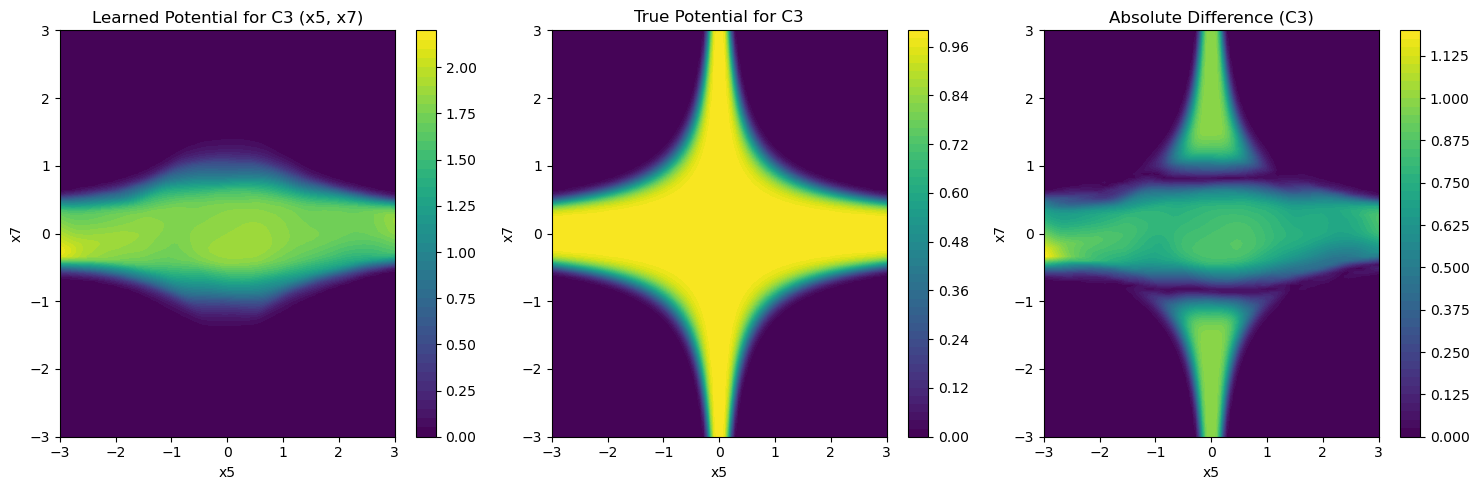

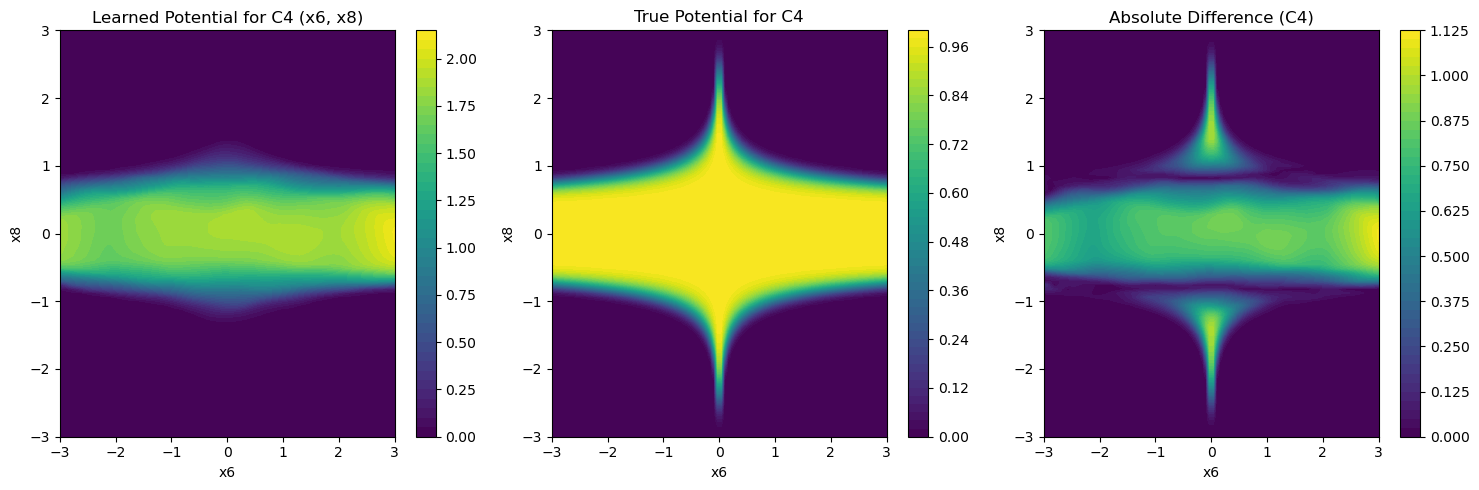

Correlation for C3: 0.8224
Correlation for C4: 0.9319


In [3]:
# visualizations

def energy_to_potential(energy):
    return torch.exp(-energy)

def create_grid(min_val=-3, max_val=3, steps=100):
    x = torch.linspace(min_val, max_val, steps)
    y = torch.linspace(min_val, max_val, steps)
    X, Y = torch.meshgrid(x, y)
    grid = torch.stack([X.flatten(), Y.flatten()], dim=1)
    return X, Y, grid

def true_phi_C3(grid):
    x5, x7 = grid[:, 0], grid[:, 1]
    return torch.exp(-x5**4 * x7**6)

def true_phi_C4(grid):
    x6, x8 = grid[:, 0], grid[:, 1]
    return torch.exp(-x6**2 * x8**8)

X, Y, grid = create_grid(-3, 3, 100)

with torch.no_grad():
    learned_energy_C3 = C3_model(grid)
    learned_potential_C3 = energy_to_potential(learned_energy_C3).reshape(X.shape)
    true_potential_C3 = true_phi_C3(grid).reshape(X.shape)
    
    learned_energy_C4 = C4_model(grid)
    learned_potential_C4 = energy_to_potential(learned_energy_C4).reshape(X.shape)
    true_potential_C4 = true_phi_C4(grid).reshape(X.shape)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.contourf(X.numpy(), Y.numpy(), learned_potential_C3.numpy(), 50)
plt.colorbar()
plt.title('Learned Potential for C3 (x5, x7)')
plt.xlabel('x5'); plt.ylabel('x7')

plt.subplot(1, 3, 2)
plt.contourf(X.numpy(), Y.numpy(), true_potential_C3.numpy(), 50)
plt.colorbar()
plt.title('True Potential for C3')
plt.xlabel('x5'); plt.ylabel('x7')

plt.subplot(1, 3, 3)
diff_C3 = (learned_potential_C3 - true_potential_C3).abs().numpy()
plt.contourf(X.numpy(), Y.numpy(), diff_C3, 50)
plt.colorbar()
plt.title('Absolute Difference (C3)')
plt.xlabel('x5'); plt.ylabel('x7')

plt.tight_layout()
plt.savefig('C3_potential_comparison.png')
plt.show()

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.contourf(X.numpy(), Y.numpy(), learned_potential_C4.numpy(), 50)
plt.colorbar()
plt.title('Learned Potential for C4 (x6, x8)')
plt.xlabel('x6'); plt.ylabel('x8')

plt.subplot(1, 3, 2)
plt.contourf(X.numpy(), Y.numpy(), true_potential_C4.numpy(), 50)
plt.colorbar()
plt.title('True Potential for C4')
plt.xlabel('x6'); plt.ylabel('x8')

plt.subplot(1, 3, 3)
diff_C4 = (learned_potential_C4 - true_potential_C4).abs().numpy()
plt.contourf(X.numpy(), Y.numpy(), diff_C4, 50)
plt.colorbar()
plt.title('Absolute Difference (C4)')
plt.xlabel('x6'); plt.ylabel('x8')

plt.tight_layout()
plt.savefig('C4_potential_comparison.png')
plt.show()

def compute_correlation(true_potential, learned_potential):
    true_flat = true_potential.flatten().numpy()
    learned_flat = learned_potential.flatten().numpy()
    return np.corrcoef(true_flat, learned_flat)[0, 1]

print(f"Correlation for C3: {compute_correlation(true_potential_C3, learned_potential_C3):.4f}")
print(f"Correlation for C4: {compute_correlation(true_potential_C4, learned_potential_C4):.4f}")


 Note, I modified the Clique 2 function. The post in ED clarified that we can correct it if needed, though it's not necessary. I corrected it: 
 [ED Discussion Post](https://edstem.org/us/courses/71247/discussion/6438737)